# Example for the `Producer-Consumer` framework

The `Producer-Consumer` is a specific design-pattern for multi-threaded applications where a function, named the `producer` produces a stream of item and a second thread, named the `consumer`, consumes the stream of items to apply a function on them. This `consumer` can also returns the result of the function and then can also become a `producer` which can have its own `consumer` etc. 

This framework gives some classes that automates the creation of `producer-consumer` with the `observer` design pattern : it means that a `consumer` is an *observer of the producer*, it observes when an item is produced and process it. If the consumer does not have any item to process, it does nothing. 

The framework provides many features such as :
- `LIFO / FIFO / Priority` buffers : you can specify the `buffer` argument to specify which kind of buffer you want for `consumers`. You can then specify the `priority` when calling the `append` (or `__call__`) `consumer`'s function. 
- mullti-consumers : as it is based on the `observer` pattern, a `Producer` can have multiple `observers` and then have multiple `Consumers` waiting for the same item.
- `start / stop listeners` : by default, `listeners` (or `observers`) waits for an item but you can also add functions that are executed at the start / end of the thread.
- `batching` : a `consumer` can process a batch of items (if multiple items are available) instead of single items. 
- `multi / mono-threading` : in the original `producer-consumer` design, each `producer / consumer` is a different thread but you can have multiple threads executing the same `consumer`. This feature is supported as well as mono-threading : running all functions in the main thread. This allows to easily swap between multi-threaded and mono-threaded execution. 
- `statefulness` : sometimes, a `consumer` can have an *internal state* (like an accumulator) which is updated accross iterations. This feature is available by specifying `stateful = True`.
- `Graph visualization` : the `observer` pattern allows to build trees of `Producer-Consumers` where the root is the `Producer` while nodes are `Consumer`. With the `graphviz` library, it is possible to build graphs and export them as `svg / pdf` files.

In the `example_generic` notebook, you have an example for the `ThreadedQueue` object which can be seen as a `Consumer` but it has some other features that `Consumer` does not have (especially when you want to keep results with a custom buffer).

A `Consumer` does not *require* a `Producer`, you can also *manually* adds items by calling the `append` (or `__call__`) `consumer`'s function.

**WARNING** : python is by mono-threaded by design, meaning that multiple threads will be executed in parallel but only 1 thread is executed at any time, due to the `python Global Interpreter Lock (GIL)`. The only exception to this behavior is when `I/O` are performed : the `I/O` operations are well executed in parallel of the execution thread. It is therefore **highly recommanded** to use this framework only when `I/O` are used (e.g. for camera / micro streaming applications, or for saving functions). 

## Example 1 : simple producer

The `add_listener` function simply adds a new `observer` that listens to a specific event (either `start, stop` or `item` (default)). A listener on `item` takes as first argument the produced item. 

In [1]:
from utils.thread_utils import Producer, Consumer, Pipeline

def counter():
    """ Generates numbers from 0 to 5 (excluded) """
    for i in range(5):
        yield i

prod = Producer(counter, run_main_thread = True)

prod.add_listener(lambda: print('Start !'), on = 'start')
prod.add_listener(lambda: print('Stop !'), on = 'stop')
prod.add_listener(lambda item: print('Item produced : {}'.format(item)))
prod.start()
print('Execution finished !')

Start !
Item produced : 0
Item produced : 1
Item produced : 2
Item produced : 3
Item produced : 4
Stop !
Execution finished !


In this example, you can observe that `Execution finished` is displayed before the end of the producer : it is executed in another thread.

In [2]:
from utils.thread_utils import Producer, Consumer, Pipeline

def counter():
    """ Generates numbers from 0 to 5 (excluded) """
    for i in range(5):
        yield i

prod = Producer(counter)

prod.add_listener(lambda: print('Start !'), on = 'start')
prod.add_listener(lambda: print('Stop !'), on = 'stop')
prod.add_listener(lambda item: print('Item produced : {}'.format(item)))
prod.start()
print('Execution finished !')

Start !
Item produced : 0
Item produced : 1
Item produced : 2
Item produced : 3
Item produced : 4
Stop !
Execution finished !


## Example 2 : simple `producer-consumer`

Let's analyze this messy output :
- Each function (producer and the 2 consumers) are executed in different threads (it is the reason why the output is quite messy). 
- The function `add_consumer` automatically creates a `Consumer` and starts it.
- The `link_stop` argument allows to stop the consumer when the producer stops while `add_listener` simply adds a listener. It is the reason why `cons2` is stopped once the producer is stopped but not `cons1`.
- The `join()` call allows to wait until the thread is finished. The `recursive` argument allows to wait for the current thread and all its children (children are the thread's `consumers`).

Note : calling `join()` on `cons1` will not block as it will internally calls `stop_when_empty()` which calls `stop()` once the `Consumer`'s buffer is empty (which will be the case at the end of the execution). 
Another alternative is to call `prod.join(recursive = True)` which calls `join` on each children once the thread is joined : it allows to wait that each node in the `producer-consumer tree` is finished.

In [3]:
import time

from utils.thread_utils import Producer, Consumer, Pipeline

def counter():
    """ Generates numbers from 0 to 5 (excluded) """
    for i in range(5):
        time.sleep(1e-3)
        yield i

def square(x):
    """ Returns the square of x """
    time.sleep(1e-3)
    return x ** 2

def cube(x):
    """ Returns the cube of x """
    time.sleep(1e-3)
    return x ** 3

prod = Producer(counter)

cons1 = Consumer(square)
cons1.add_listener(lambda item, ** kwargs: print('Item produced by cons1 : {}'.format(item)))
cons1.add_listener(lambda: print('Start cons1 !'), on = 'start')
cons1.add_listener(lambda: print('Stop cons1 !'), on = 'stop')

cons2 = prod.add_consumer(
    cube, link_stop = True, start_listeners = lambda: print('Start cons2 !'), stop_listeners = lambda: print('Stop cons2 !')
)
cons2.add_listener(lambda item, ** kwargs: print('Item produced by cons2 : {}'.format(item)))

prod.add_listener(cons1)
prod.add_listener(lambda: print('Start !'), on = 'start')
prod.add_listener(lambda: print('Stop !'), on = 'stop')
prod.add_listener(lambda item: print('Item produced by producer : {}'.format(item)))
prod.start()
cons1.start()
# prod.join(recursive = True)
prod.join()
cons2.join()
print('Execution finished !')

Start cons2 !
Start !
Start cons1 !
Item produced by producer : 0
Item produced by cons2 : 0
Item produced by cons1 : 0
Item produced by producer : 1
Item produced by cons1 : 1
Item produced by producer : 2
Item produced by cons2 : 1
Item produced by cons1 : 4
Item produced by cons2 : 8
Item produced by producer : 3
Item produced by cons1 : 9
Item produced by cons2 : 27
Item produced by producer : 4
Stop !
Item produced by cons2 : 64
Stop cons2 !
Execution finished !
Item produced by cons1 : 16


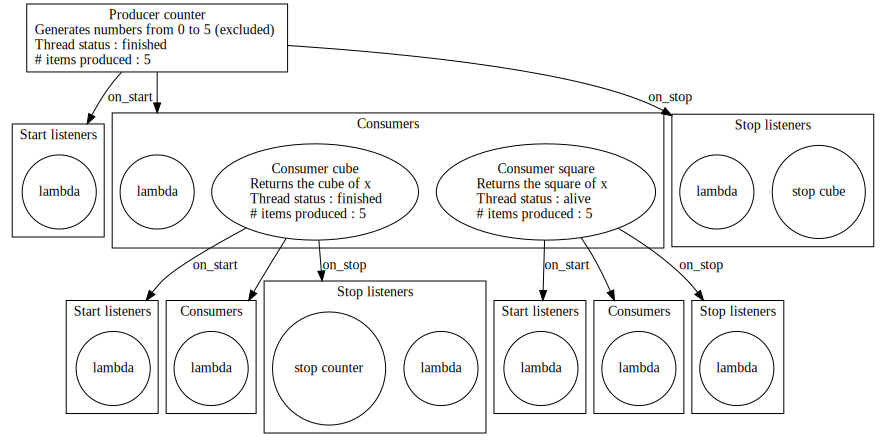

In [4]:
prod.plot(name = 'Producer with multiple consumers', view = False)[0]

## Example 3 : real-life example - camera streaming

This example comes from `utils/image/image_io.py`. It better illustrates the `producer-consumer` design in a real-life example. 

Note that the code is a bit more complex than a simple camera streaming due to the `fps` argument : the objective is to get / show frames with the appropriate rate by taking care of the getting / showing time. 

On the below graph, we can observe : 
- The release of the video reader / writer are performed in the `stop_listener` meaning that they are executed once their respective thread is finished (once all frames have been produced / consumed). 

The big advantage of this` producer-consumer` pattern is that *auxiliary functions* do not impact the main streaming pipeline : the `write_video` does not slow down the streaming while being executed. If everything is executed sequentially, you should wait the frame is written before reading the next frame. 
In practice, for detection with `YOLOv2` in streaming on the camera, it has allowed me to go from 15 to >20 fps !

In [ ]:
import os
import cv2
import logging
import numpy as np

from loggers import set_level, timer
from utils.image import *

set_level('time')

DELAY_MS = 5

@timer
def stream_camera(cam_id    = 0,
                  max_time  = 60,
                  nb_frames = -1,
                  
                  fps   = -1,
                  show_fps  = None,
                  
                  max_workers   = 0,
                  
                  id_format = None,
                  transform_fn  = None,
                  transformer_prod  = None,
                  
                  output_file   = None,
                  output_fps    = None,
                  output_shape  = None,
                  
                  show  = True,
                  play_audio    = False,
                  copy_audio    = True,
                  
                  view_graph        = False,
                  output_graph      = False,
                  graph_filename    = None,
                  
                  ** kwargs
                 ):
    """
        Streams either on a camera either on a video file (depending on `cam_id`) and applies `transformer_fn` on each frame.
        
        Arguments :
            - cam_id    : camera ID (0 is default camera) or video filename (str)
            - max_time  : the maximum streaming time (press 'q' to quit before if `show = True`)
            - nb_frames : number of frames to stream (quit after)
            
            - fps   : frames per second for the input stream
            - show_fps  : frames per second for the `cv2.imshow` call
            
            - max_workers   : number of workers for each `Consumer`
                - -1 / -2   : each function is executed in the main thread (no separated thread) 
                - 0     : each function is executed in a separate thread
                - > 0   : each function is executed in `n` separated threads
            
            - id_format : the name format for the ith frame. If provided, the generator's output (i.e. the input to `transform_fn`) is a dict {id: , image:} where `id_format` is formatted with the frame index
            - transform_fn  : valid argument to the `add_consumer` method. Its input is either a dict (if `id_format` is provided) either the frame
            - transformer_prod  : a `Consumer` object that outputs the transformed frames to display (default to `prod.add_consumer(transform_fn)`)
            
            - output_file   : the output filename to save the (transformed) video
            - output_fps    : the fps for the output video file
            - output_shape  : output shape of the transformed video (default to the camera / input file's shape)
            
            - show  : whether to display the result or not (with `cv2.imshow`)
            - play_audio    : whether to play the audio (ignored if `cam_id` is not a video file)
            - copy_audio    : whether to copy the input file's audio to the output's file
            
            - kwargs    : kwargs passed to the `transform_fn` pipeline
    """
    def should_continue(t0, t, n):
        run = True
        if max_time is not None:    run = run and t - t0 < max_time
        if nb_frames > 0:           run = run and n < nb_frames
        return run
    
    def frame_producer_new():
        """ Produces `fps` frames per second from `cap` """
        time_between_frames = 1. / fps
        
        n = 0
        t = time.time()
        next_time = t
        while should_continue(start_time, t, n):
            if t < next_time: time.sleep(next_time - t)
            next_time += time_between_frames
            ret, frame = cap.read()
            if ret: yield frame[..., ::-1]
            n += 1
            t = time.time()

    def frame_producer():
        """ Produces `fps` frames per second """
        n = 0
        start_iter_time = time.time()
        while should_continue(start_time, start_iter_time, n):
            ret, frame = cap.read()
            if ret:
                frame = frame[..., ::-1]
                yield frame if id_format is None else {
                    'id' : id_format.format(n), 'image' : frame
                }
            
            n += 1
            wait_time = wait_time_sec - (time.time() - start_iter_time)
            if fps > 0 and wait_time > 0: time.sleep(wait_time)
            start_iter_time = time.time()

    @timer
    def write_video(frame):
        """ Writes frames to the corresponding output file """
        frame = convert_to_uint8(frame, ** kwargs)
        video_writer.write(frame[:, :, ::-1])
    
    @timer
    def show_frame(frame, prev_time = -1):
        """ Displays `fps` frames per second with `cv2.imshow` """
        cv2.imshow(display_name, frame[..., ::-1])
        
        t = time.time()
        delay    = 0 if prev_time == -1 else (t - prev_time)
        delay_ms = int(delay * 1000)
        if cv2.waitKey(max(show_wait_time_ms - delay_ms, 1)) & 0xFF == ord('q'):
            raise StopIteration()
        return None, (time.time(), )
    
    def _play_first_frame(frame, first = True):
        """ Runs the audio once the first frame has been displayed """
        if first:
            from utils.audio import audio_io
            audio_io.play_audio(cam_id, block = False)
        return None, (False, )
    # variable initialization
    if max_time <= 0:        max_time = None
    if transform_fn is None:    id_format   = None
    
    display_name = '{} {}'.format('Camera' if isinstance(cam_id, int) else 'File', cam_id)
    cap = cv2.VideoCapture(cam_id)
    
    if output_fps is None: output_fps = fps
    # if streaming is not on camera but on video file
    if isinstance(cam_id, str):
        video_frames    = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        nb_frames   = video_frames if nb_frames <= 0 else min(nb_frames, video_frames)
        output_fps  = cap.get(cv2.CAP_PROP_FPS)
        logger.info('Start streaming on a video with {:.3f} fps and {} frames'.format(
            output_fps, video_frames
        ))
    
    # set the output fps
    if output_file and output_fps == -1:
        logger.warning('When specifying an `output_file`, it is recommanded to specify `output_fps` as the `fps` can differ from the effective camera fps')
        output_fps  = cap.get(cv2.CAP_PROP_FPS) if fps == -1 else fps
    # set the display fps
    if play_audio and isinstance(cam_id, str):
        show_fps    = output_fps
    elif show_fps is None:
        show_fps    = fps
    # set the waiting time according to the frame rate
    wait_time_ms    = int(max(1000 // fps - DELAY_MS + 1, 1))
    wait_time_sec   = wait_time_ms / 1000.
    
    show_wait_time_ms    = int(max(1000 // show_fps - DELAY_MS + 1, 1))
    show_wait_time_sec   = show_wait_time_ms / 1000.

    #####################
    # Init the pipeline #
    #####################
    
    prod = Producer(
        frame_producer, run_main_thread = max_workers < 0, stop_listeners = cap.release
    )
    
    transformer = prod.add_consumer(
        transform_fn, link_stop = True, max_workers = max_workers, ** kwargs
    ) if transform_fn is not None else prod
    
    if transformer_prod is None: transformer_prod = transformer
    # Adds a frame writer if required
    if output_file is not None:
        if output_shape is None:
            frame_h     = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_w     = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        else:
            frame_h, frame_w = output_shape

        video_writer    = cv2.VideoWriter(
            output_file, cv2.VideoWriter_fourcc(*'MPEG'), output_fps, (frame_w, frame_h)
        )
        # Creates the video-writer consumer
        writer_cons     = transformer_prod.add_consumer(
            write_video, link_stop = True, start = True, max_workers = min(max_workers, 0),
            stop_listeners = video_writer.release
        )
        # Adds a listener to copy the video file's audio to the output file (if expected)
        if copy_audio:
            from utils.image import video_utils
            writer_cons.add_listener(
                lambda: video_utils.copy_audio(cam_id, output_file), on = 'stop'
            )
    
    # Adds a consumer to display frames (if expected)
    if show:
        cons = transformer_prod.add_consumer(
            show_frame, start = True, link_stop = True, stateful = True,
            max_workers     = min(max_workers, 0),
            start_listeners = lambda: cv2.namedWindow(display_name, cv2.WINDOW_NORMAL),
            stop_listeners  = cv2.destroyAllWindows
        )
        if play_audio and output_fps != -1 and isinstance(cam_id, str):
            cons.add_consumer(_play_first_frame, on = 'item', stateful = True, max_workers = -1)
    
    start_time = time.time()
    
    prod.start()
    graph = prod.plot(filename = graph_filename, view = view_graph)[0] if view_graph or graph_filename or output_graph else None
    # waits until all consumers are finished
    prod.join(recursive = True)
    
    total_time = time.time() - start_time
    logger.info("Streaming processed {} frames in {} ({:.2f} fps)".format(
        prod.size, time_to_string(total_time), prod.size / total_time
    ))
    return graph

stream_camera(
    cam_id       = '../__test_datas/video_test.mp4',
    output_file  = '__test_output.mp4',
    copy_audio   = True,
    play_audio   = True,
    
    view_graph     = True,
    graph_filename = 'video_streaming_graph.gv',
    output_graph   = True
)